# Proyecto final

Link de la presentación: https://drive.google.com/drive/folders/1USB5y_WHoJsCj_RRtMsNZVqDaoleH1r0?usp=sharing

## Importación de datos

In [1]:
#Importacion de los modulos requeridos

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_1samp

In [2]:
#Importación de los datasets

tel_clients = pd.read_csv('telecom_clients_us.csv')
tel_data = pd.read_csv('telecom_dataset_us.csv')

## Visualización y preprocesamiento de los datos

In [3]:
print(tel_clients.info())
print(tel_clients.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None
   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16


In [4]:
#Conversion a tipo datetime en la columna date_start

tel_clients['date_start'] = pd.to_datetime(tel_clients['date_start'])
print(tel_clients.info())
print(tel_clients.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB
None
   user_id tariff_plan date_start
0   166713           A 2019-08-15
1   166901           A 2019-08-23
2   168527           A 2019-10-29
3   167097           A 2019-09-01
4   168193           A 2019-10-16


In [5]:
print(tel_data.info())
print(tel_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None
   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out

In [6]:
#Eliminamos del dataframe los operadores no asignados (NaN)
df = tel_data[tel_data['operator_id'].notna()]
df['operator_id'] = df['operator_id'].astype(int)

# Filtrar solo llamadas entrantes
df = df[df['direction'] == 'in']

C:\Users\zero2\AppData\Local\Temp\ipykernel_21700\2539922377.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['operator_id'] = df['operator_id'].astype(int)


In [7]:
# Agrupamos por operador
operator_metrics = df.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    missed_calls=('is_missed_call', lambda x: (x * df.loc[x.index, 'calls_count']).sum()),
    total_duration=('total_call_duration', 'sum'),
    call_duration=('call_duration', 'sum')
)

# Porcentaje de llamadas perdidas
operator_metrics['missed_call_pct'] = operator_metrics['missed_calls'] / operator_metrics['total_calls']

# Diferencia entre tiempo total y tiempo real de llamada
operator_metrics['duration_diff'] = operator_metrics['total_duration'] - operator_metrics['call_duration']

# Diferencia promedio por llamada
operator_metrics['avg_duration_diff'] = operator_metrics['duration_diff'] / operator_metrics['total_calls']

In [8]:
# Cálculo de percentiles
p75_missed = operator_metrics['missed_call_pct'].quantile(0.75)
p50_diff = operator_metrics['avg_duration_diff'].quantile(0.5)

# Identificamos ineficientes
operator_metrics['inefficient'] = (
    (operator_metrics['missed_call_pct'] > p75_missed) |
    (operator_metrics['avg_duration_diff'] > p50_diff)
)

In [9]:
inefficient_ops = operator_metrics[operator_metrics['inefficient']]

print(f"Número total de operadores: {operator_metrics.shape[0]}")
print(f"Número de operadores ineficientes detectados: {inefficient_ops.shape[0]}")

# Mostrar algunos ejemplos
inefficient_ops.sort_values(by='missed_call_pct', ascending=False).head(10)

Número total de operadores: 754
Número de operadores ineficientes detectados: 464


,total_calls,missed_calls,total_duration,call_duration,missed_call_pct,duration_diff,avg_duration_diff,inefficient
operator_id,,,,,,,,
948756,1,1,58,50,1.000000,8,8.000000,True
904344,7,6,366,273,0.857143,93,13.285714,True
913886,2,1,65,38,0.500000,27,13.500000,True
906392,19,7,970,715,0.368421,255,13.421053,True
957922,3,1,712,686,0.333333,26,8.666667,True
937432,3,1,86,50,0.333333,36,12.000000,True
934098,6,2,204,45,0.333333,159,26.500000,True
906412,26,7,1385,985,0.269231,400,15.384615,True
910226,8,2,479,347,0.250000,132,16.500000,True


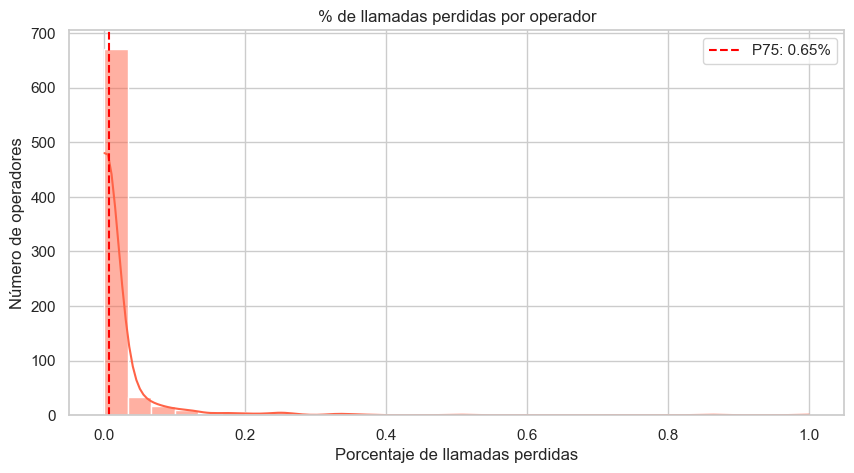

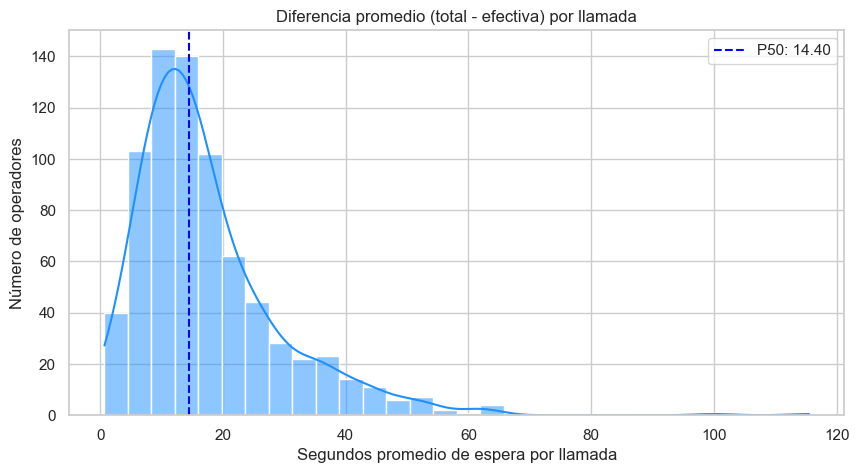

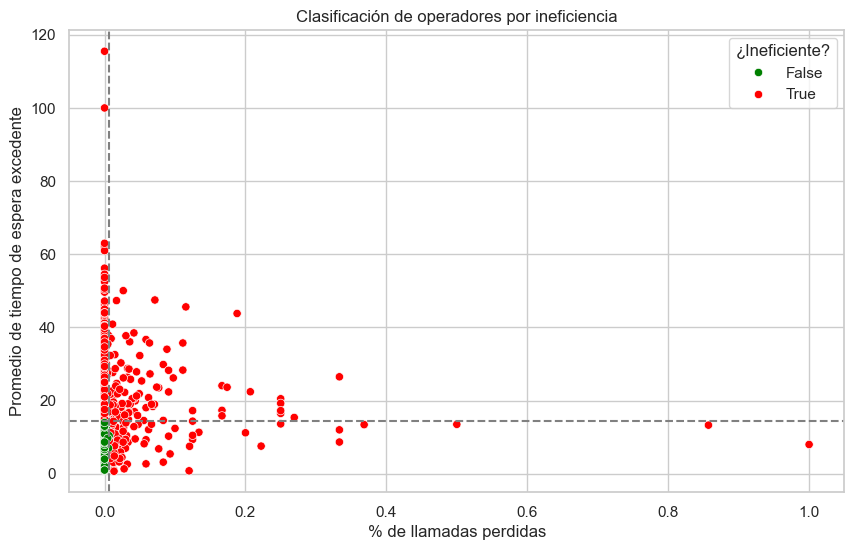

In [10]:
sns.set(style='whitegrid', palette='muted')

# Histograma del % de llamadas perdidas
plt.figure(figsize=(10, 5))
sns.histplot(operator_metrics['missed_call_pct'], bins=30, kde=True, color='tomato')
plt.axvline(p75_missed, color='red', linestyle='--', label=f'P75: {p75_missed:.2%}')
plt.title('% de llamadas perdidas por operador')
plt.xlabel('Porcentaje de llamadas perdidas')
plt.ylabel('Número de operadores')
plt.legend()
plt.show()

# Histograma de diferencia promedio de duración
plt.figure(figsize=(10, 5))
sns.histplot(operator_metrics['avg_duration_diff'], bins=30, kde=True, color='dodgerblue')
plt.axvline(p50_diff, color='blue', linestyle='--', label=f'P50: {p50_diff:.2f}')
plt.title('Diferencia promedio (total - efectiva) por llamada')
plt.xlabel('Segundos promedio de espera por llamada')
plt.ylabel('Número de operadores')
plt.legend()
plt.show()

# Scatter plot eficiencia
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=operator_metrics,
    x='missed_call_pct',
    y='avg_duration_diff',
    hue='inefficient',
    palette={True: 'red', False: 'green'}
)
plt.axvline(p75_missed, color='gray', linestyle='--')
plt.axhline(p50_diff, color='gray', linestyle='--')
plt.title('Clasificación de operadores por ineficiencia')
plt.xlabel('% de llamadas perdidas')
plt.ylabel('Promedio de tiempo de espera excedente')
plt.legend(title='¿Ineficiente?')
plt.show()

## Pruebas estadisticas

### Prueba de porcentaje de llamadas perdidas

In [11]:
# Métricas agregadas
total_missed = operator_metrics['missed_calls'].sum()
total_calls = operator_metrics['total_calls'].sum()
overall_rate = total_missed / total_calls

# Eliminar operadores sin llamadas (no se puede hacer test con ellos)
metrics_with_calls = operator_metrics[operator_metrics['total_calls'] > 0].copy()

metrics_with_calls['z_score'] = np.nan
metrics_with_calls['p_value'] = np.nan

for idx, row in metrics_with_calls.iterrows():
    count = row['missed_calls']
    nobs = row['total_calls']
    stat, pval = proportions_ztest(count, nobs, value=overall_rate, alternative='larger')
    metrics_with_calls.at[idx, 'z_score'] = stat
    metrics_with_calls.at[idx, 'p_value'] = pval

# Operadores con resultados significativos
metrics_with_calls['significantly_inefficient'] = metrics_with_calls['p_value'] < 0.05

c:\Users\zero2\anaconda3\Lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


In [12]:
metrics_with_calls[['missed_calls', 'total_calls', 'missed_call_pct', 'p_value', 'significantly_inefficient']].head()

print(f"Número de operadores ineficientes detectados por la prueba estadistica: {metrics_with_calls[metrics_with_calls['significantly_inefficient'] == True].shape[0]}")

Número de operadores ineficientes detectados por la prueba estadistica: 36


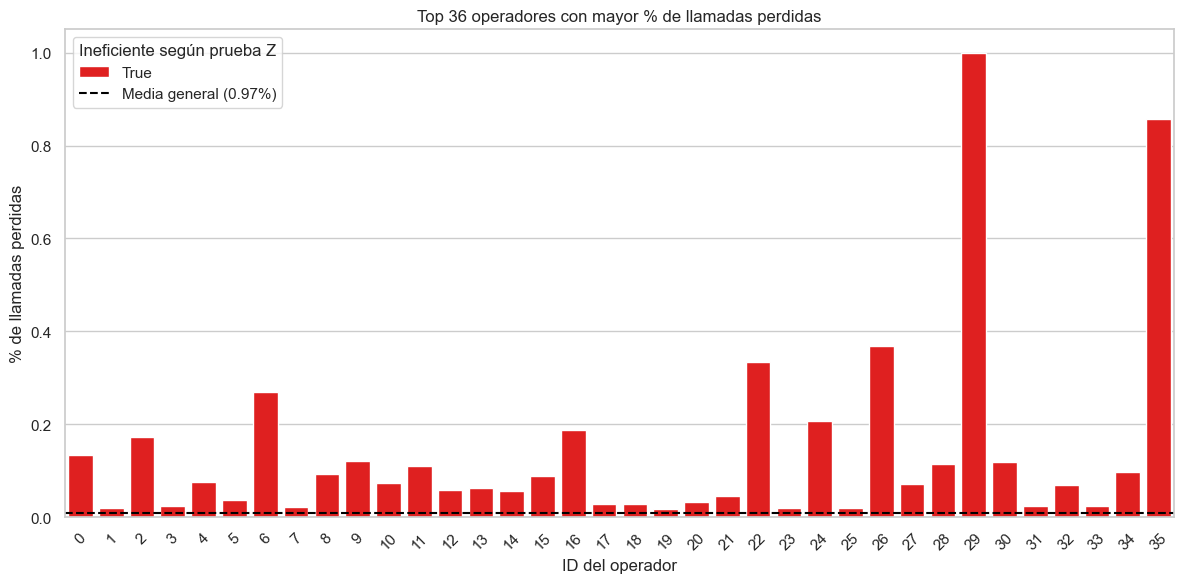

In [13]:
df_plot = metrics_with_calls.sort_values('significantly_inefficient', ascending=False).reset_index(drop=True)

# Mostrar los operadores ineficientes por % de llamadas perdidas
top_n = 36
df_top = df_plot.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_top,
    x=df_top.index,
    y='missed_call_pct',
    hue='significantly_inefficient',
    palette={True: 'red', False: 'green'},
    dodge=False
)

plt.axhline(overall_rate, color='black', linestyle='--', label=f'Media general ({overall_rate:.2%})')
plt.title(f'Top {top_n} operadores con mayor % de llamadas perdidas')
plt.xlabel('ID del operador')
plt.ylabel('% de llamadas perdidas')
plt.legend(title='Ineficiente según prueba Z')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=df_plot,
    x='operator_id',
    y='missed_call_pct',
    hue='significantly_inefficient',
    palette={True: 'red', False: 'green'},
    s=60
)

plt.axhline(overall_rate, color='black', linestyle='--', label=f'Media general ({overall_rate:.2%})')
plt.title('Tasa de llamadas perdidas por operador')
plt.xlabel('ID del operador')
plt.ylabel('% de llamadas perdidas')
plt.legend(title='Ineficiente según prueba Z')
plt.tight_layout()
plt.show()


ValueError: Could not interpret value `operator_id` for `x`. An entry with this name does not appear in `data`.

<Figure size 1400x600 with 0 Axes>

### Prueba para la diferencia promedio por llamada

In [ ]:
# Media global de diferencia promedio por llamada
global_avg_diff = df['total_call_duration'].sum() - df['call_duration'].sum()
global_avg_diff /= df['calls_count'].sum()

print(f"Media global de diferencia por llamada: {global_avg_diff:.2f} segundos")

# Calculamos diferencia por llamada
df['duration_diff_per_call'] = (df['total_call_duration'] - df['call_duration']) / df['calls_count']
df_clean = df[df['calls_count'] > 0]  # para evitar división por cero

# Diccionario para guardar resultados
t_test_results = {}

for op_id, group in df_clean.groupby('operator_id'):
    diffs = group['duration_diff_per_call'].dropna()
    if len(diffs) < 5:
        continue  # evitamos tests con pocos datos

    t_stat, p_value = ttest_1samp(diffs, global_avg_diff, alternative='greater')
    t_test_results[op_id] = {
        't_stat': t_stat,
        'p_value': p_value,
        'num_calls': len(diffs)
    }

# Convertimos a DataFrame
t_test_df = pd.DataFrame.from_dict(t_test_results, orient='index')
t_test_df.index.name = 'operator_id'
t_test_df.reset_index(inplace=True)

Media global de diferencia por llamada: 13.14 segundos


In [ ]:
operator_metrics = operator_metrics.merge(t_test_df, on='operator_id', how='left')

# Etiquetar operadores con diferencia significativamente alta
operator_metrics['significantly_slow'] = operator_metrics['p_value_y'] < 0.05

In [ ]:
operator_metrics[operator_metrics['significantly_slow']].sort_values('p_value').head()

,operator_id,total_calls,missed_calls,total_duration,call_duration,missed_call_pct,duration_diff,avg_duration_diff,inefficient,z_score,p_value_x,significantly_inefficient,t_stat_x,p_value_y,num_calls_x,t_stat_y,p_value,num_calls_y,significantly_slow
334,919554,1346,11,173073,129548,0.008172,43525,32.336553,True,-0.642750,0.739807,False,48.641975,4.423540e-63,84.0,48.641975,4.423540e-63,84.0,True
333,919552,1239,1,198849,156534,0.000807,42315,34.152542,True,-11.084294,1.000000,False,38.646232,1.432491e-51,76.0,38.646232,1.432491e-51,76.0,True
335,919790,1793,0,179488,119862,0.000000,59626,33.254880,True,-inf,1.000000,False,26.905170,6.069149e-39,71.0,26.905170,6.069149e-39,71.0,True
217,906406,836,3,114791,92251,0.003589,22540,26.961722,True,-2.979114,0.998555,False,32.907910,2.545006e-36,52.0,32.907910,2.545006e-36,52.0,True
230,907502,263,2,18413,13146,0.007605,5267,20.026616,True,-0.400446,0.655586,False,23.455491,1.958877e-33,65.0,23.455491,1.958877e-33,65.0,True


In [ ]:
print(f"Número de operadores ineficientes detectados por la prueba estadistica: {operator_metrics[operator_metrics['significantly_slow'] == True].shape[0]}")

Número de operadores ineficientes detectados por la prueba estadistica: 202


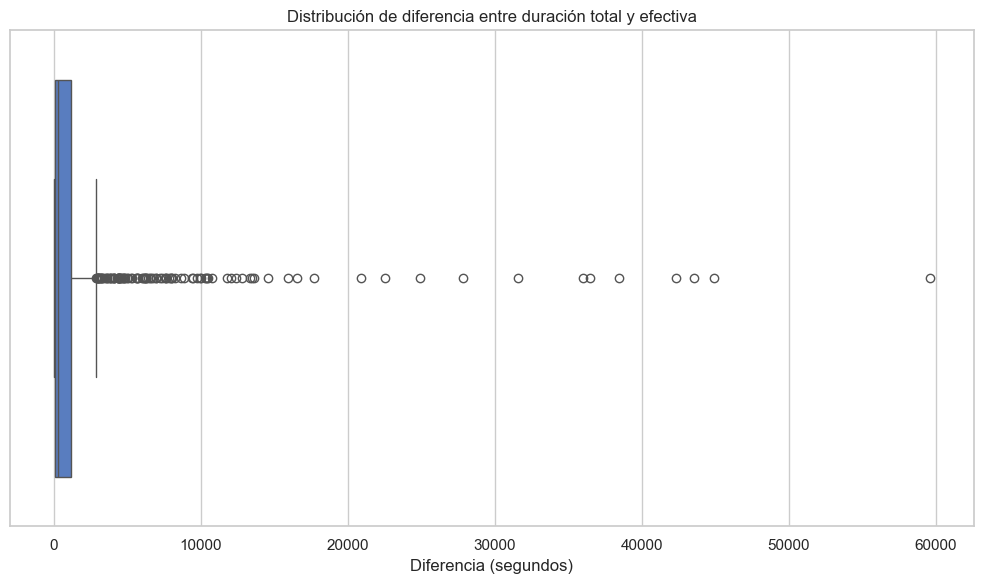

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=operator_metrics, x='duration_diff')
plt.title('Distribución de diferencia entre duración total y efectiva')
plt.xlabel('Diferencia (segundos)')
plt.tight_layout()
plt.show()

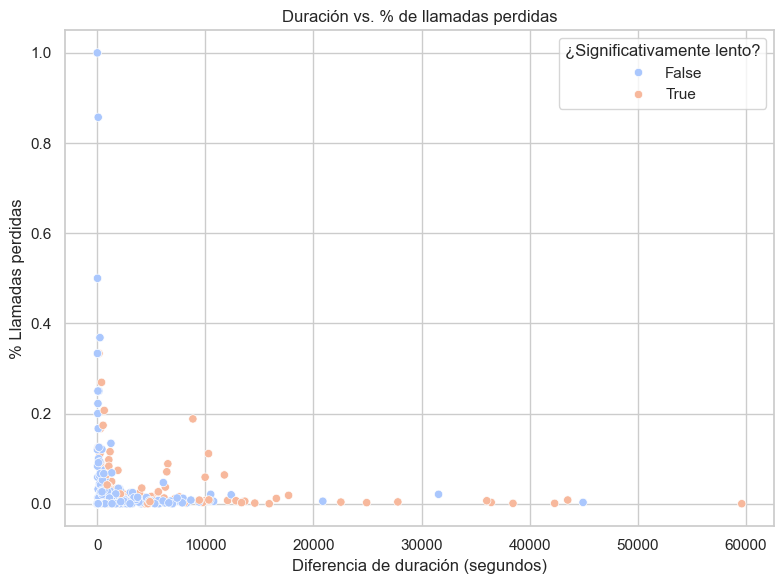

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=operator_metrics, x='duration_diff', y='missed_call_pct', hue='significantly_slow', palette='coolwarm')
plt.title('Duración vs. % de llamadas perdidas')
plt.xlabel('Diferencia de duración (segundos)')
plt.ylabel('% Llamadas perdidas')
plt.legend(title='¿Significativamente lento?')
plt.tight_layout()
plt.show()